<a href="https://colab.research.google.com/github/aslanides/aslanides.github.io/blob/master/colabs/2019-09-24-pandas-basics-iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Back to basics with pandas and plotnine

In [0]:
# @title Imports

import numpy as np
import pandas as pd
import plotnine as gg
import requests
import sklearn

## Let there be data

Let's fetch the famous [Iris dataset] from the UCI [machine learning datasets] repository.

[Iris dataset]: https://archive.ics.uci.edu/ml/datasets/iris
[machine learning datasets]: https://archive.ics.uci.edu/ml

In [0]:
# The URL for the raw data in text form.
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

# Column names/metadata.
feature_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
target_columns = ['target']

In [0]:
# Fetch the raw data from the website.
response = requests.get(url=data_url)
rows = response.text.split('\n')
data = [r.split(',') for r in rows]

# Turn it into a dataframe and drop any null values.
df = pd.DataFrame(data, columns=feature_columns + target_columns)
df.dropna(inplace=True)

# Fix up the data types: features are numeric, targets are categorical.
df[feature_columns] = df[feature_columns].astype('float')
df[target_column] = df[target_column].astype('category')

## Take a quick look at the data

In [103]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [104]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
target          150 non-null category
dtypes: category(1), float64(4)
memory usage: 6.1 KB


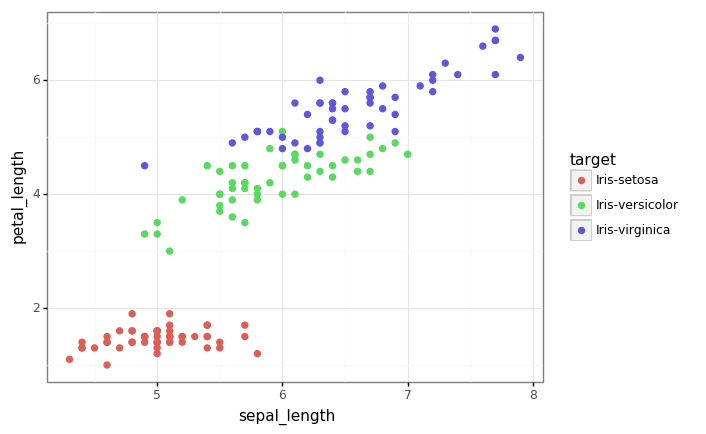

<ggplot: (-9223363286024448838)>

In [89]:
# Let's take a look at the data.
gg.theme_set(gg.theme_bw())

p = (gg.ggplot(df)
     + gg.aes(x='sepal_length', y='petal_length', color='target')
     + gg.geom_point(size=2)
    )
p

## Fitting a simple linear model

In [0]:
model = sklearn.linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial')

In [0]:
X = df[feature_columns].values
y = df[target_column].cat.codes

In [78]:
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred_df = df.copy()
pred_df['prediction'] = model.predict(X).astype('int8')
pred_df['correct'] = pred_df.prediction == pred_df.target.cat.codes
accuracy = pred_df.correct.sum() / len(pred_df)

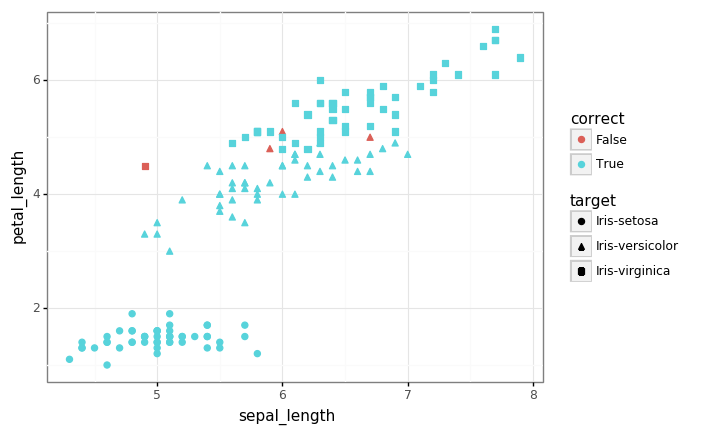

<ggplot: (8750829994795)>

In [120]:
# Let's take a look at the data.

p = (gg.ggplot(pred_df)
     + gg.aes(x='sepal_length', y='petal_length', shape='target', color='correct')
     + gg.geom_point(size=2)
    )
p